### Look at T and S diffusivity difference with double diffusion parameterization ON versus OFF

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import sys
sys.path.append('/home/users/birgal/')

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'

In [3]:
ds_daily  = xr.open_dataset(f'{base_dir}ERA5-forcing/daily/files/processed/t2m_time_y1979.nc').isel(time=slice(0,31))
ds_hourly = xr.open_dataset(f'{base_dir}ERA5-forcing/t2m_y1979m01.nc').groupby('time.day').mean()

In [10]:

ds_daily.rename({'day':'time'}
ds_daily.to_netcdf('t2m_test_y1979m01.nc', unlimited_dims={'time':True})

<xarray.Dataset> Size: 258MB
Dimensions:    (latitude: 721, longitude: 1440, day: 31)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * day        (day) int64 248B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
Data variables:
    t2m        (latitude, longitude, day) float64 257MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-01T23:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
ds_daily = ds_daily.rename({'time':'day'})
ds_daily['day'] = ds_hourly['day']

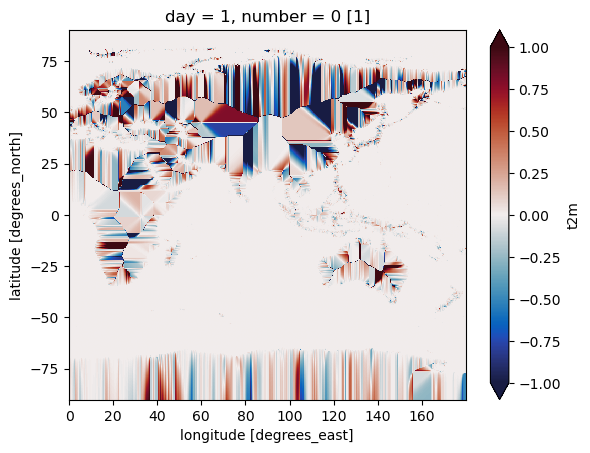

In [9]:
(ds_hourly.t2m - ds_daily.t2m).isel(day=0).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

In [15]:
# dsW0 = xr.open_dataset(f'{base_dir}output/ERA5_test10_MOAR/files0/eANT025.L121_1d_19790101_19791231_grid_W_19791001-19791001.nc')
# dsW1 = xr.open_dataset(f'{base_dir}output/ERA5_test10_ddf_MOAR/files0/eANT025.L121_1d_19790101_19791231_grid_W_19791001-19791001.nc')
year=1979
dsW0 = xr.open_dataset(f'{base_dir}output/ERA5_test10_MOAR/files0/eANT025.L121_1m_{year}0101_{year}1231_grid_W.nc').buoyancy_ratio
dsW1 = xr.open_dataset(f'{base_dir}output/ERA5_test10_ddf_MOAR/files0/eANT025.L121_1m_{year}0101_{year}1231_grid_W.nc').buoyancy_ratio

In [16]:
mask = xr.open_dataset(nemo_mesh).squeeze().tmask.rename({'nav_lev':'depthw'})

In [17]:
mask['depthw'] = dsW0.depthw

In [18]:
dsW0 = xr.where(mask==1, dsW0, np.nan)
dsW1 = xr.where(mask==1, dsW1, np.nan)

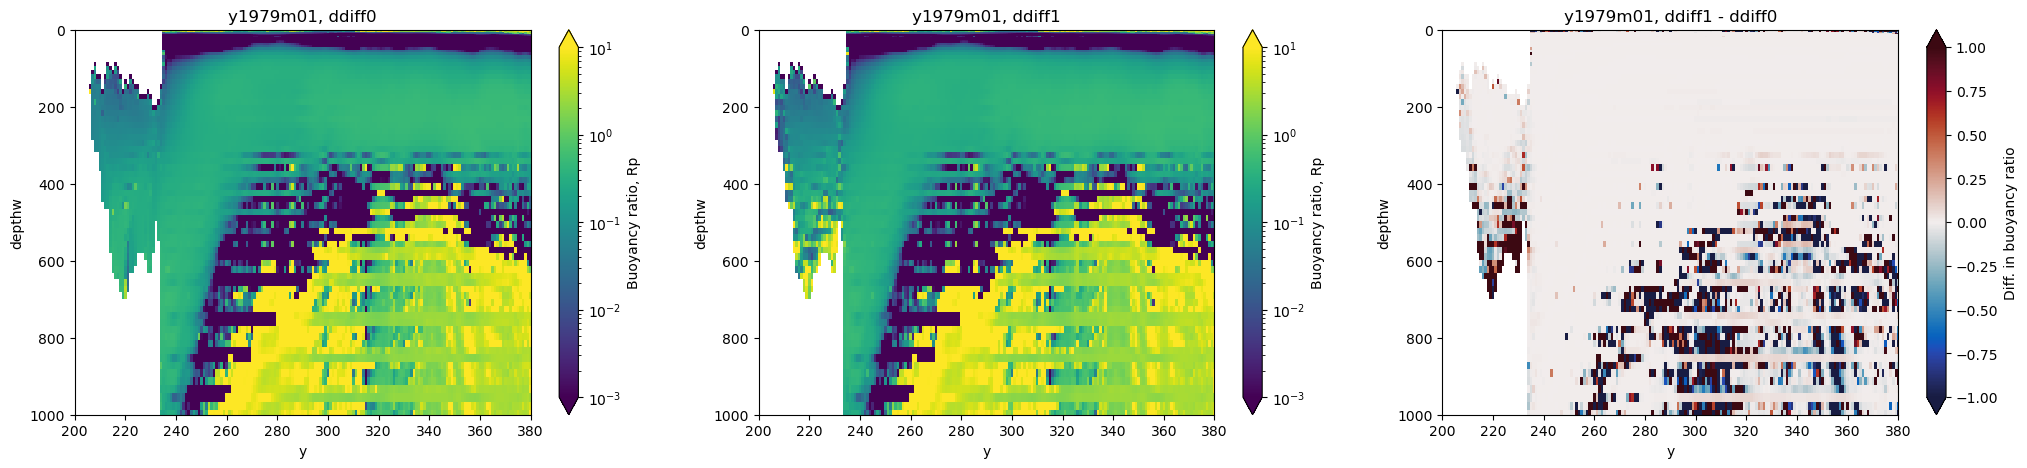

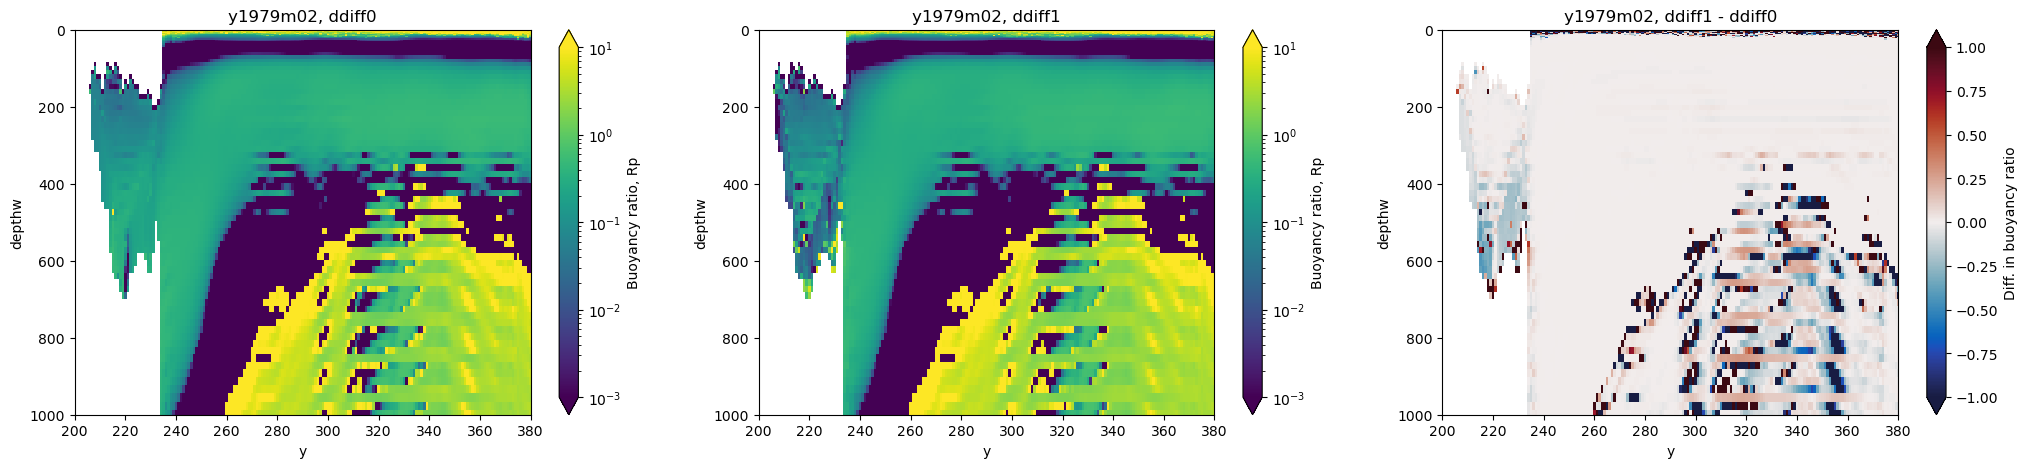

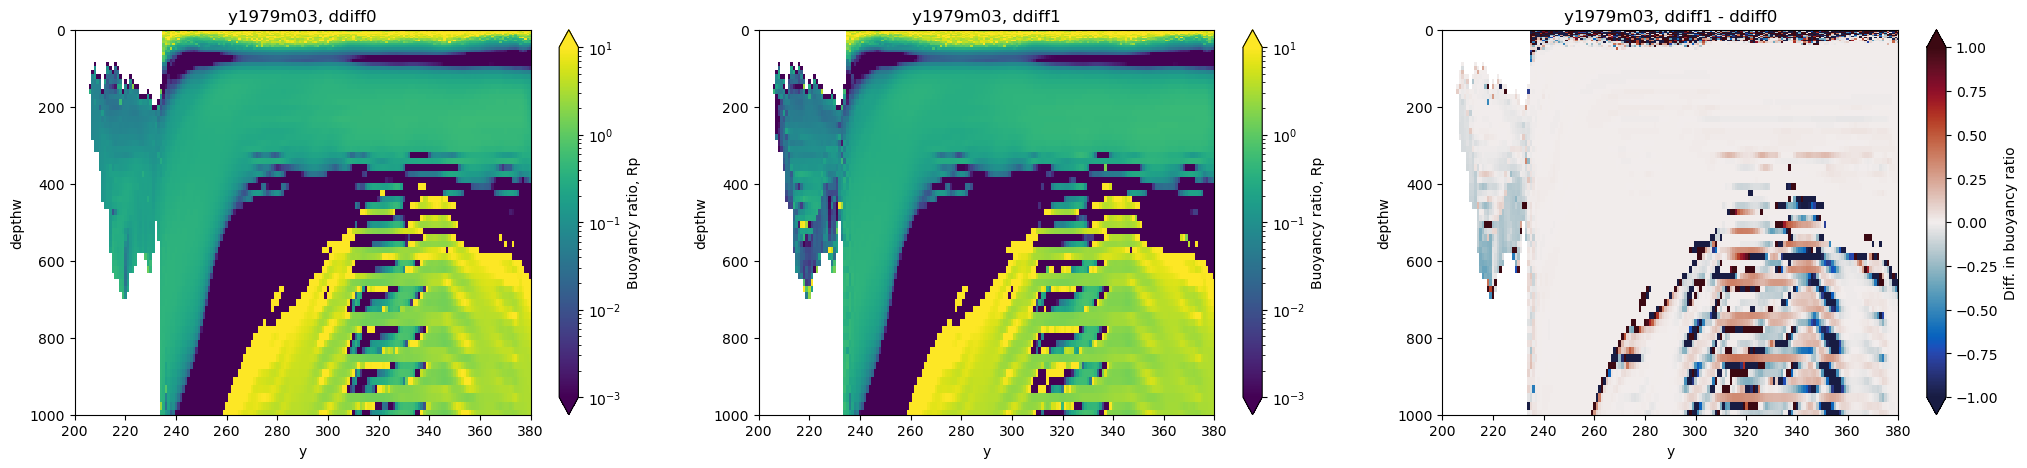

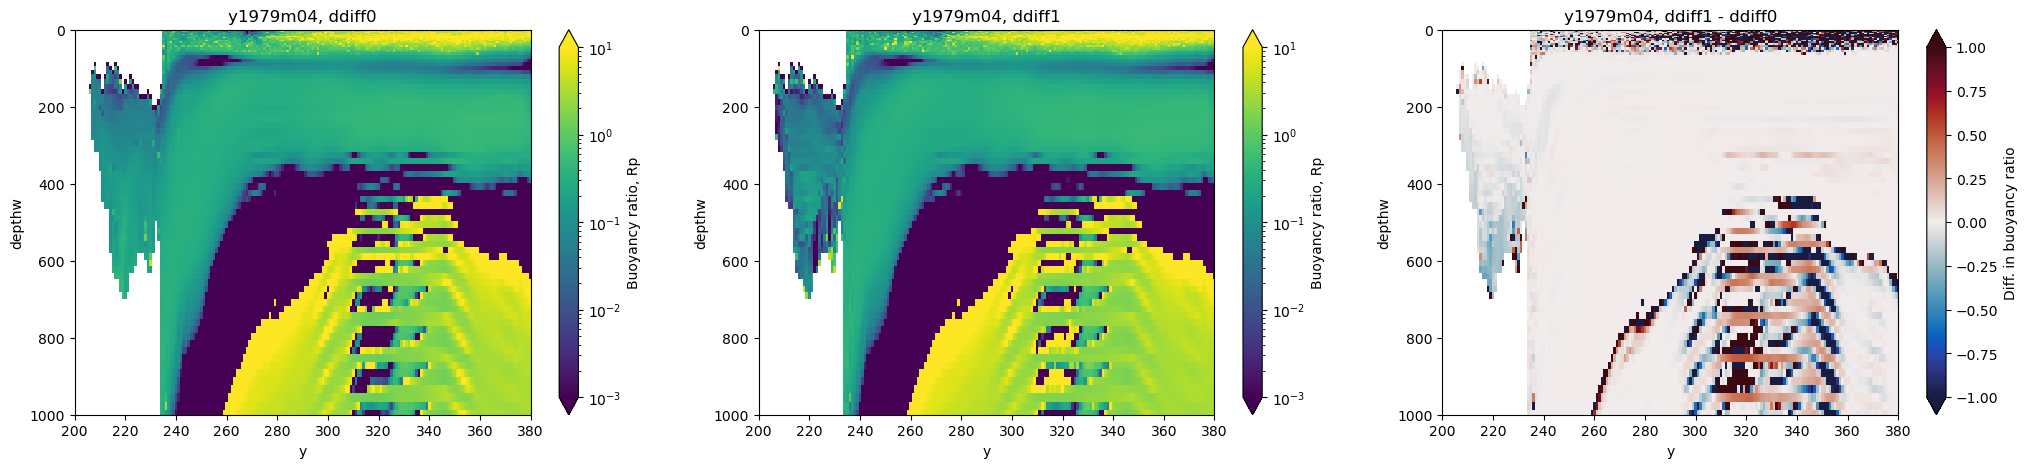

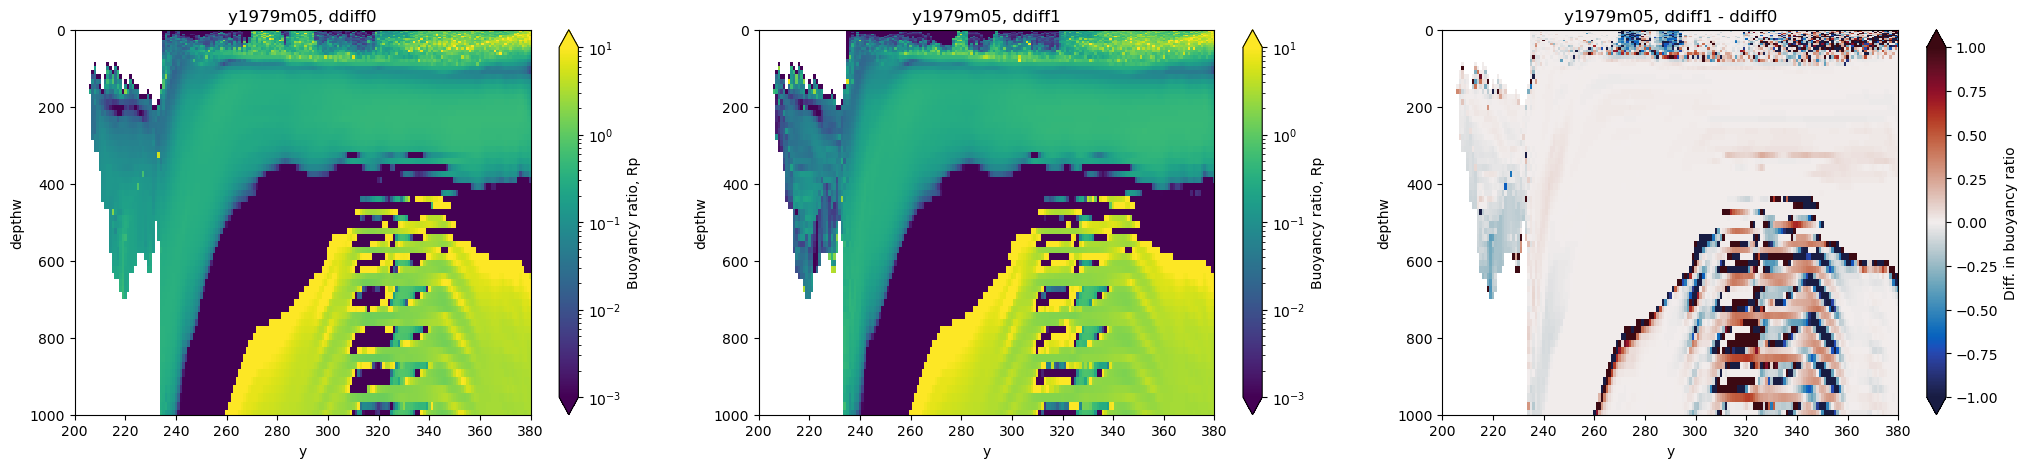

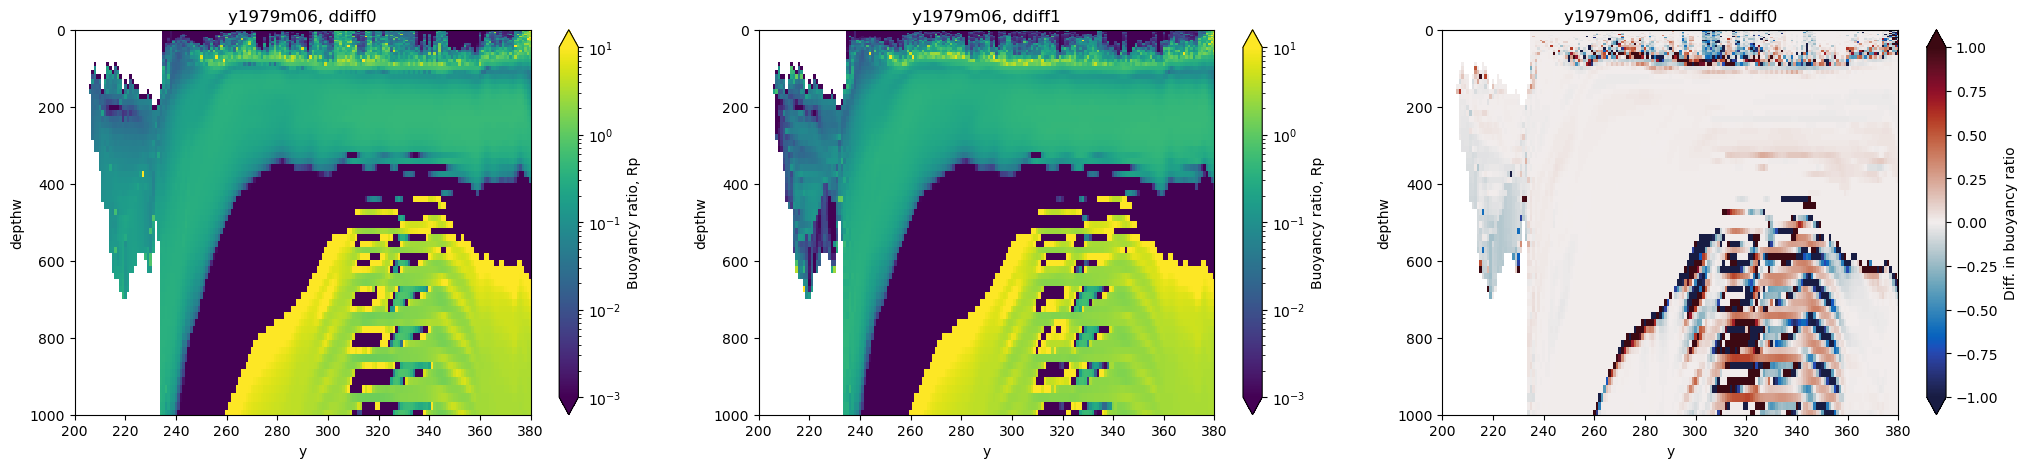

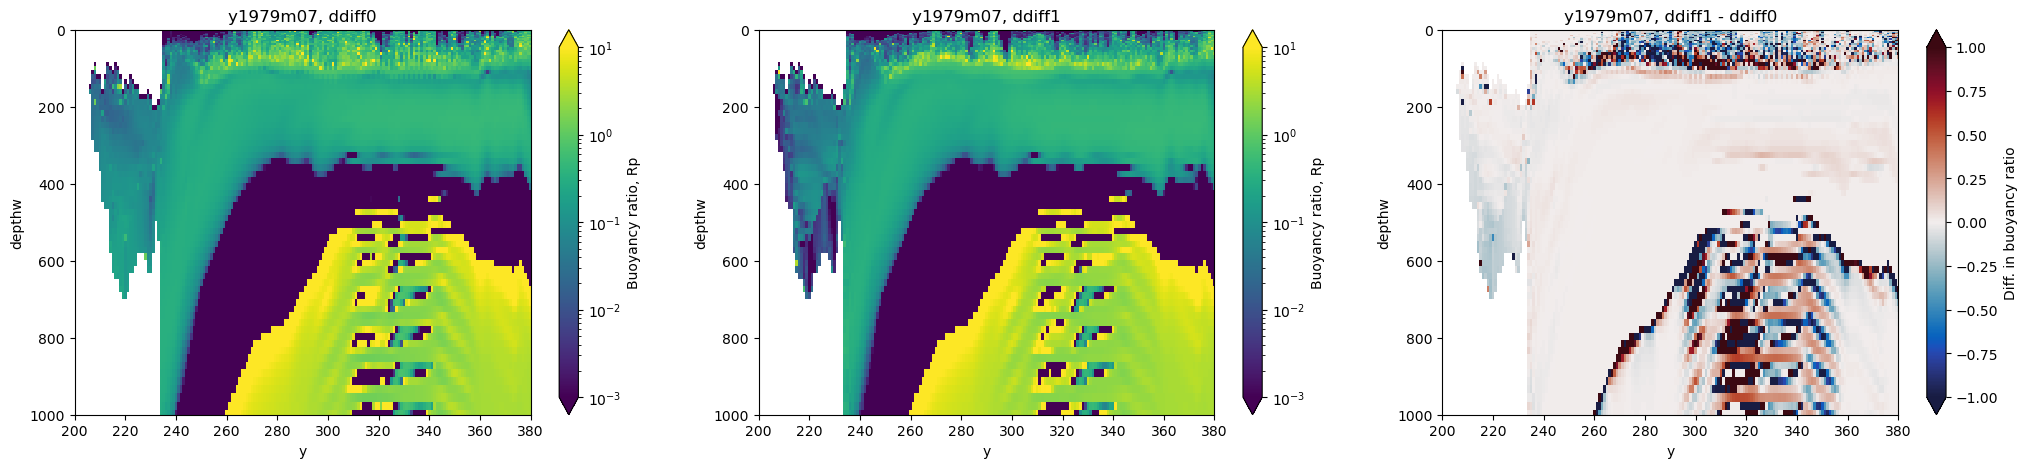

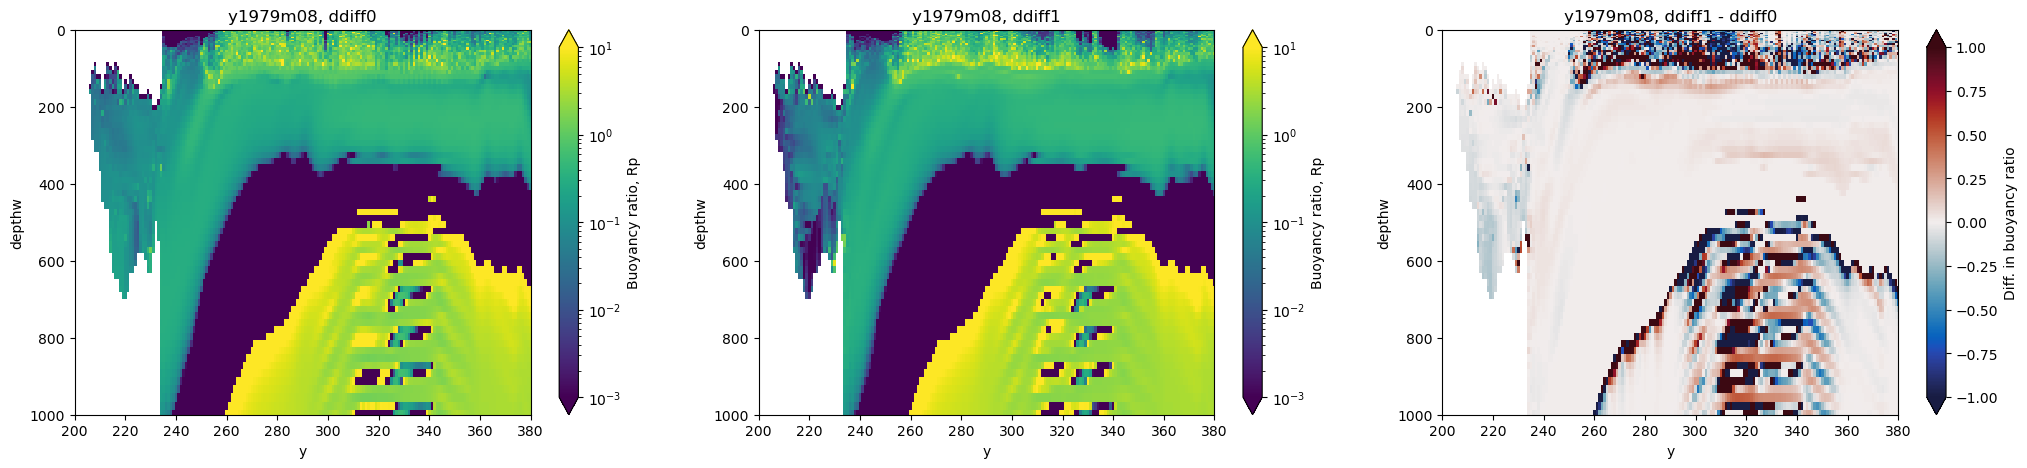

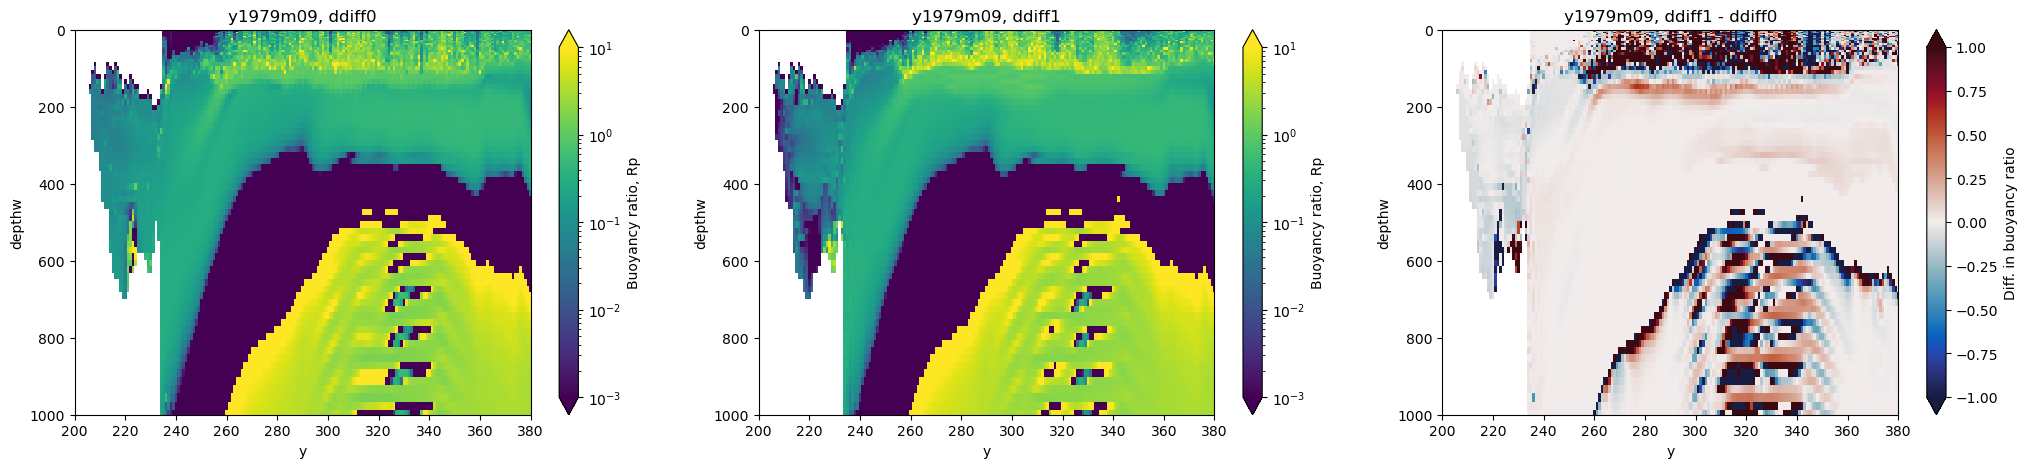

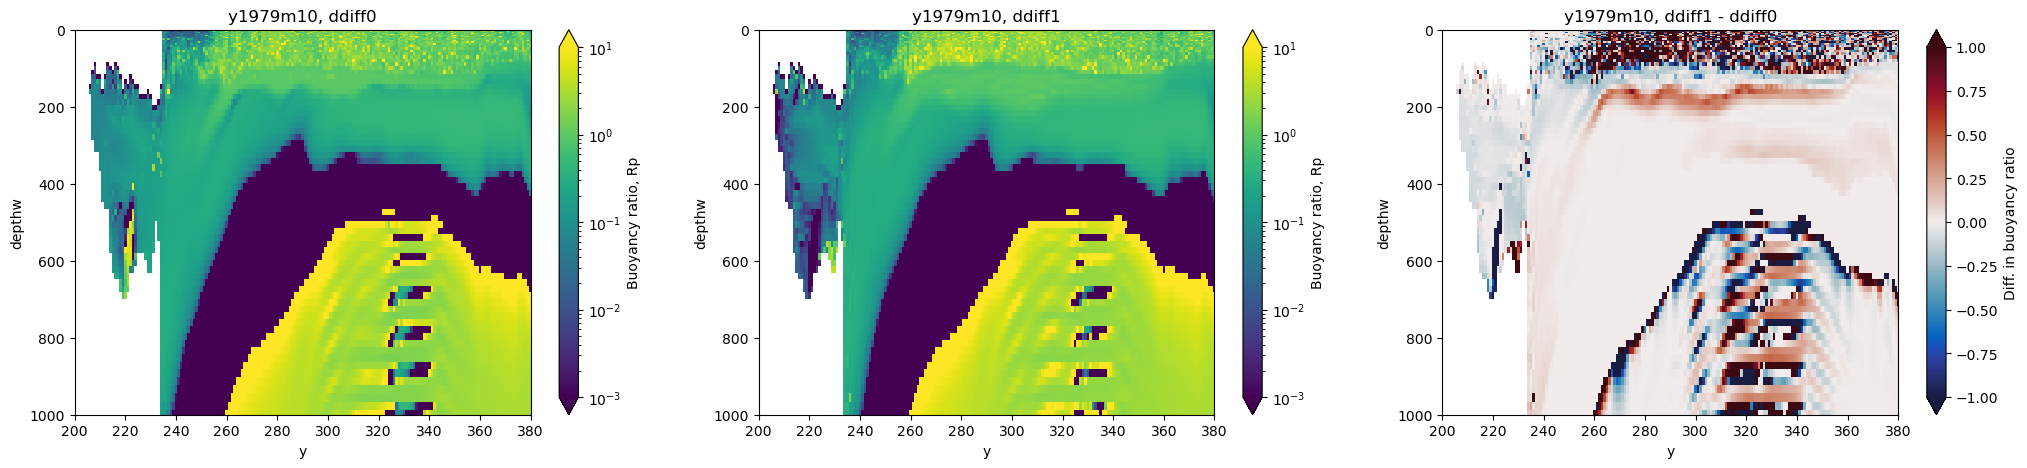

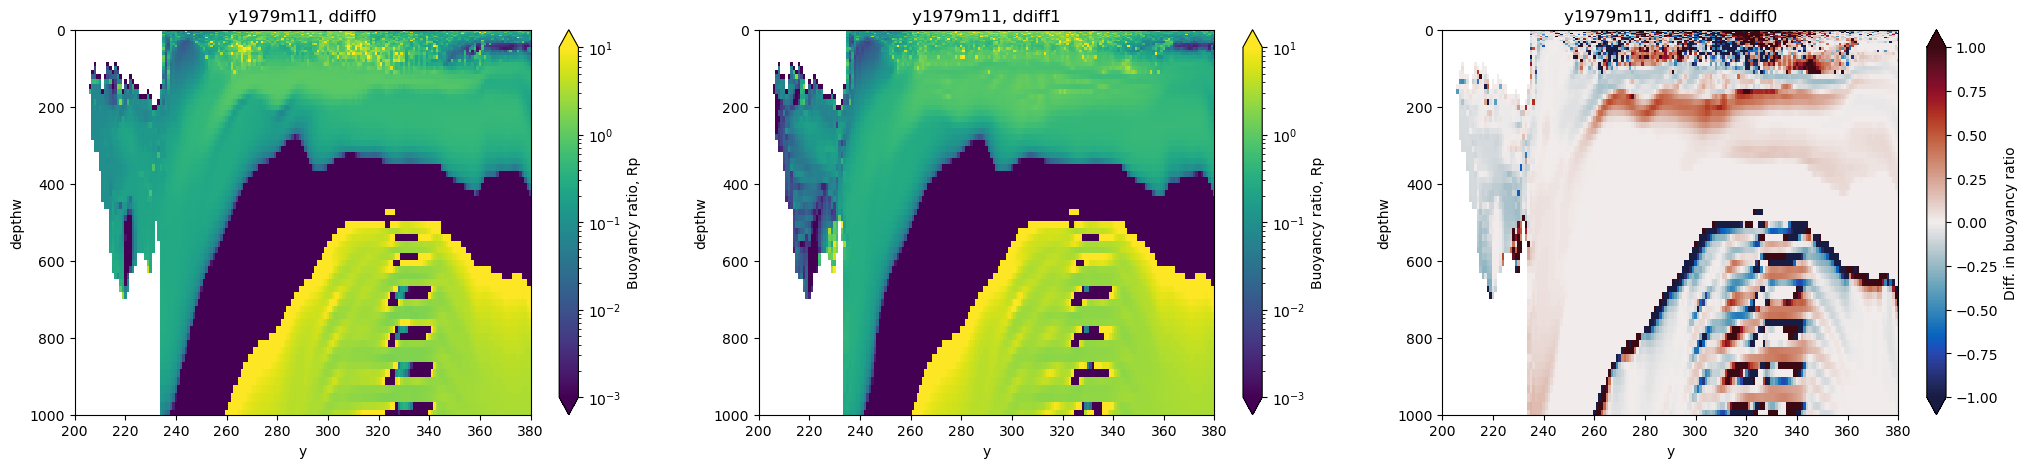

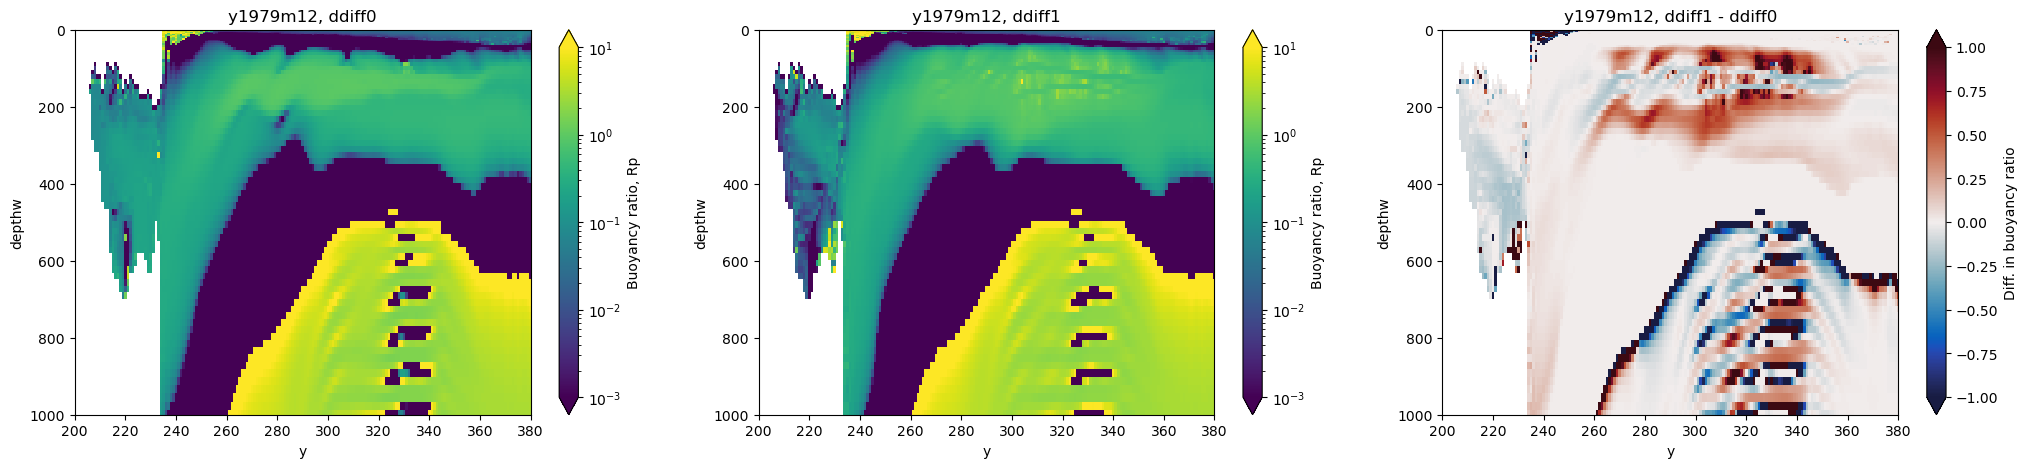

In [19]:
for month in range(0,12):

    fig, ax = plt.subplots(1,3, figsize=(25,5))
    
    dsW0.isel(month=month,x=1050).plot(vmin=1e-3, vmax=1e1, ax=ax[0], norm=colors.LogNorm(), cbar_kwargs={'label': "Buoyancy ratio, Rp"})
    dsW1.isel(month=month,x=1050).plot(vmin=1e-3, vmax=1e1, ax=ax[1], norm=colors.LogNorm(), cbar_kwargs={'label': "Buoyancy ratio, Rp"})
    (dsW1.isel(month=month,x=1050) - dsW0.isel(month=month,x=1050)).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance, ax=ax[2], 
                                                                         cbar_kwargs={'label': "Diff. in buoyancy ratio"})
    
    ax[0].set_title(f'y{year}m{month+1:02}, ddiff0')
    ax[1].set_title(f'y{year}m{month+1:02}, ddiff1')
    ax[2].set_title(f'y{year}m{month+1:02}, ddiff1 - ddiff0')
    
    for axis in ax.ravel():
        axis.set_ylim(1000,0)
        axis.set_xlim(200,380)

    fig.savefig(f'{base_dir}figures/frames/buoyancy_ratio_y{year}m{month+1:02}.jpg', bbox_inches='tight')

### Behaviour of ddif parameterization 

In [30]:
buoyancy_ratio = np.arange(0,5,0.01)

# salt fingering
salt_f_As = np.zeros(buoyancy_ratio.shape)
salt_f_At = np.zeros(buoyancy_ratio.shape)
salt_f_As = xr.where(buoyancy_ratio>1, 1e-4/(1+((buoyancy_ratio/1.6)**6)), salt_f_As)
salt_f_At = 0.7*salt_f_As/buoyancy_ratio

# diffusive layering
diff_At = np.zeros(buoyancy_ratio.shape)
diff_As = np.zeros(buoyancy_ratio.shape)
diff_At = xr.where((buoyancy_ratio<1)*(buoyancy_ratio>0)   , 1.3635e-6*np.exp(4.6*np.exp(-0.54*((1/buoyancy_ratio) - 1))), diff_At)
diff_As = xr.where((buoyancy_ratio<1)*(buoyancy_ratio>=0.5), diff_At*(1.85*buoyancy_ratio-0.85), diff_As)
diff_As = xr.where((buoyancy_ratio<=0.5)*(buoyancy_ratio>0), diff_At*0.15*buoyancy_ratio       , diff_As)

/tmp/ipykernel_11885/2445924238.py:7: RuntimeWarning: invalid value encountered in divide
  salt_f_At = 0.7*salt_f_As/buoyancy_ratio
/tmp/ipykernel_11885/2445924238.py:12: RuntimeWarning: divide by zero encountered in divide
  diff_At = xr.where((buoyancy_ratio<1)*(buoyancy_ratio>0)   , 1.3635e-6*np.exp(4.6*np.exp(-0.54*((1/buoyancy_ratio) - 1))), diff_At)


Text(0.5, 1.0, 'Temperature')

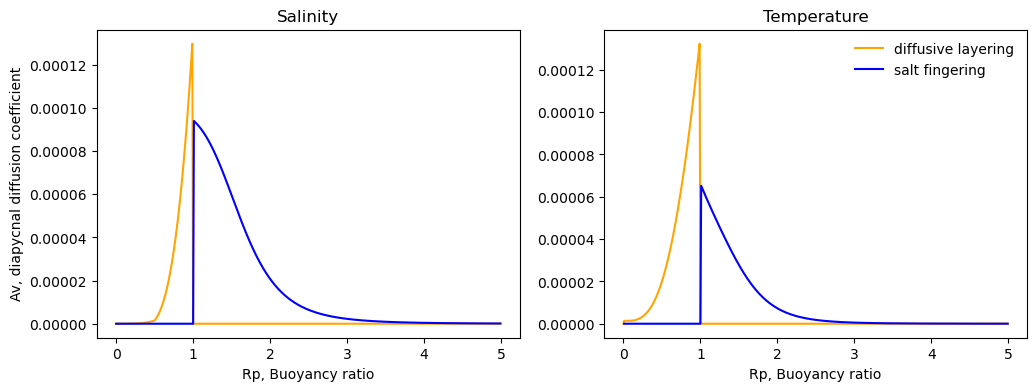

In [35]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_ylabel('Av, diapycnal diffusion coefficient')
for axis in ax.ravel():
    axis.set_xlabel('Rp, Buoyancy ratio')
    # axis.tick_params(axis='y', colors='orange')
    # axis.set_ylim(0,1e-4)

# ax1.set_ylabel('Y1 data', color='g')

ax[0].plot(buoyancy_ratio, diff_As, label='diffusive layering', c='orange')
ax[0].plot(buoyancy_ratio, salt_f_As, label='salt fingering', c='blue')
ax[1].plot(buoyancy_ratio, diff_At  , label='diffusive layering', c='orange')
ax[1].plot(buoyancy_ratio, salt_f_At, label='salt fingering', c='blue')

ax[1].legend(frameon=False)
ax[0].set_title('Salinity')
ax[1].set_title('Temperature')

## Vertical diffusivities

In [12]:
ds_on  = xr.open_dataset(f'{base_dir}output/ERA5_test10_ddf/files1/eANT025.L121_1m_19790101_19791231_grid_T.nc')
ds_off = xr.open_dataset(f'{base_dir}output/ERA5_test10/files/eANT025.L121_1m_19790101_19791231_grid_W.nc').rename({'x':'x_grid_W', 'y':'y_grid_W'})

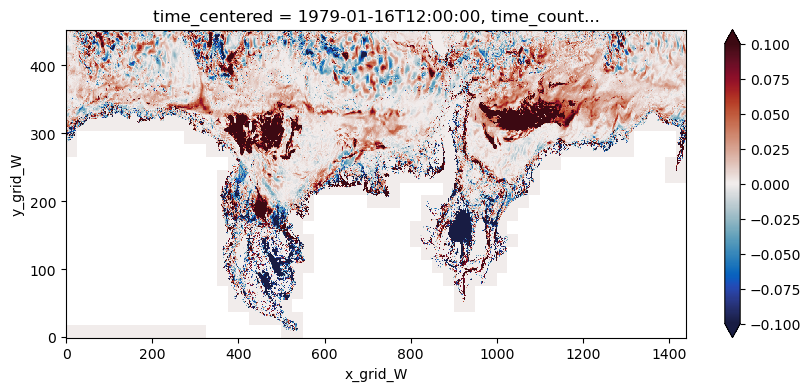

In [40]:
(ds_on.avt.isel(time_counter=0) - ds_off.difvho.isel(time_counter=0)).mean(dim='depthw').plot(figsize=(10,4), vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance)

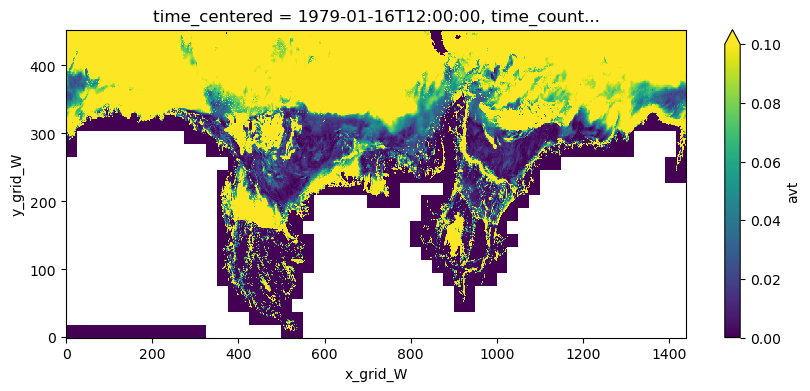

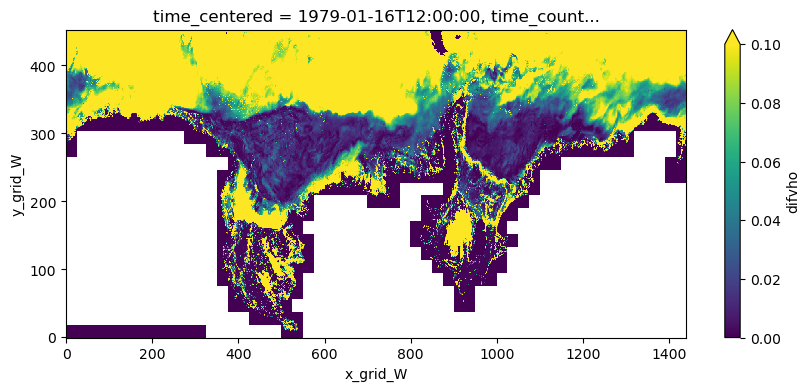

In [38]:
ds_on.avt.isel(time_counter=0).mean(dim='depthw').plot(figsize=(10,4), vmin=0, vmax=0.1)
ds_off.difvho.isel(time_counter=0).mean(dim='depthw').plot(figsize=(10,4), vmin=0, vmax=0.1)

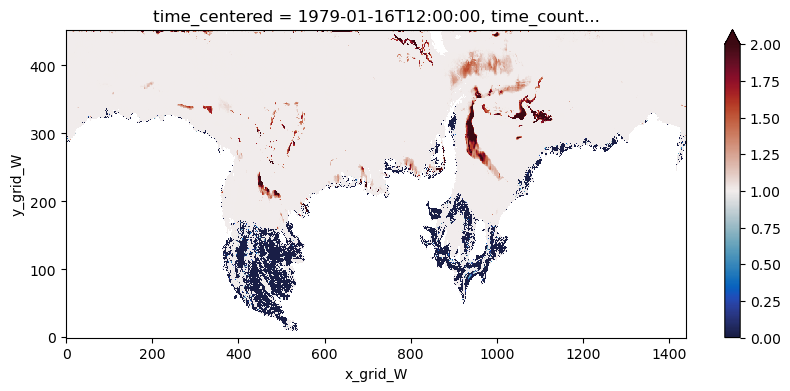

In [20]:
(ds_on.avs.isel(time_counter=0)/ds_on.avt.isel(time_counter=0)).max(dim='depthw').plot(figsize=(10,4), vmin=0, vmax=2, cmap=cmocean.cm.balance)

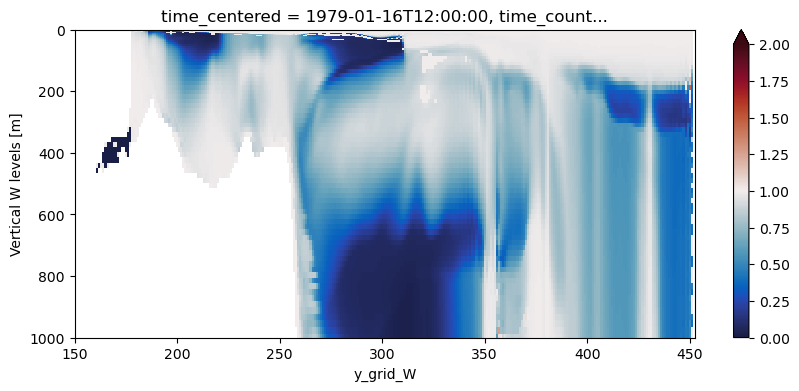

In [23]:
(ds_on.avs.isel(time_counter=0)/ds_on.avt.isel(time_counter=0)).isel(x_grid_W=950).plot(figsize=(10,4), vmin=0, vmax=2, ylim=(1000,0), xlim=(150,None), cmap=cmocean.cm.balance)

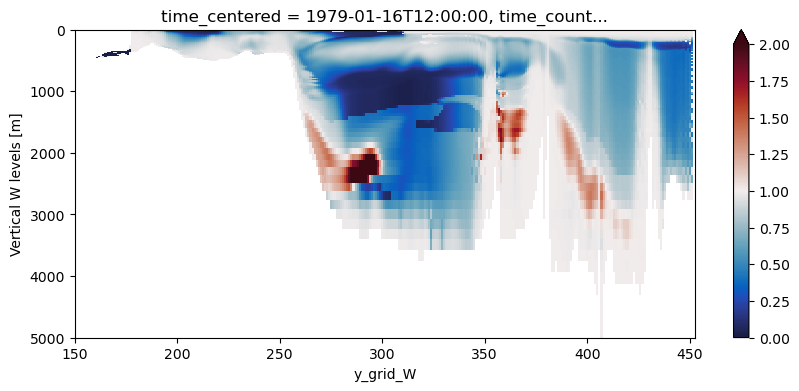

In [25]:
(ds_on.avs.isel(time_counter=0)/ds_on.avt.isel(time_counter=0)).isel(x_grid_W=950).plot(figsize=(10,4), vmin=0, vmax=2, ylim=(5000,0), xlim=(150,None), cmap=cmocean.cm.balance)

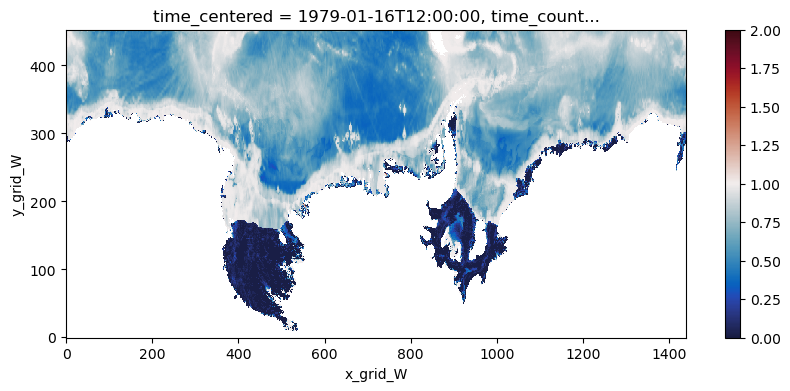

In [23]:
(ds_on.avs.isel(time_counter=0)/ds_on.avt.isel(time_counter=0)).mean(dim='depthw').plot(figsize=(10,4), vmin=0, vmax=2, cmap=cmocean.cm.balance)

In [ ]:
# cold pool problem was that in some cells the cells cool but salinity did not change, i.e. diffusivity of heat >> diffusivity of salinity.
# the relatively low avs versus avt within cavities in both max and min is consistent with this

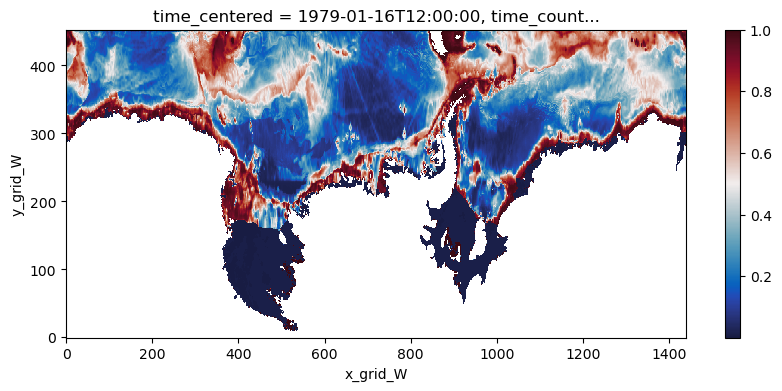

In [20]:
(ds_on.avs.isel(time_counter=0)/ds_on.avt.isel(time_counter=0)).min(dim='depthw').plot(figsize=(10,4), vmin=None, vmax=None, cmap=cmocean.cm.balance)

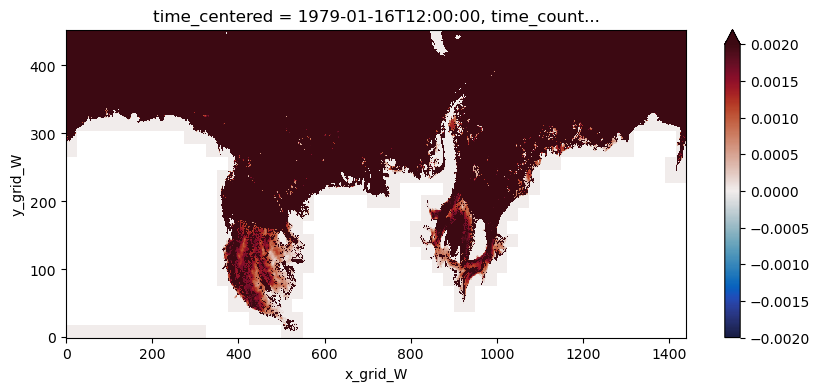

In [35]:
(ds_on.avt.isel(time_counter=0) + ds_on.avs.isel(time_counter=0)).mean(dim='depthw').plot(figsize=(10,4), vmin=-2e-3, vmax=2e-3, cmap=cmocean.cm.balance)

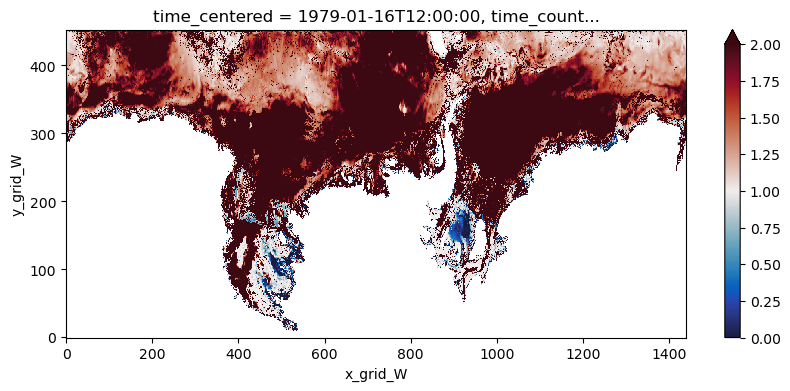

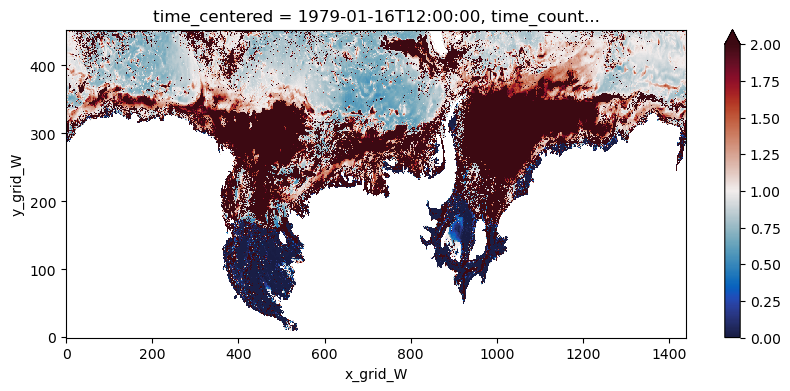

In [25]:
params = {'figsize':(10,4), 'vmin':0, 'vmax':2, 'cmap':cmocean.cm.balance}
(ds_on.avt.isel(time_counter=0)/ds_off.difvho.isel(time_counter=0)).mean(dim='depthw').plot(**params)
(ds_on.avs.isel(time_counter=0)/ds_off.difvho.isel(time_counter=0)).mean(dim='depthw').plot(**params)

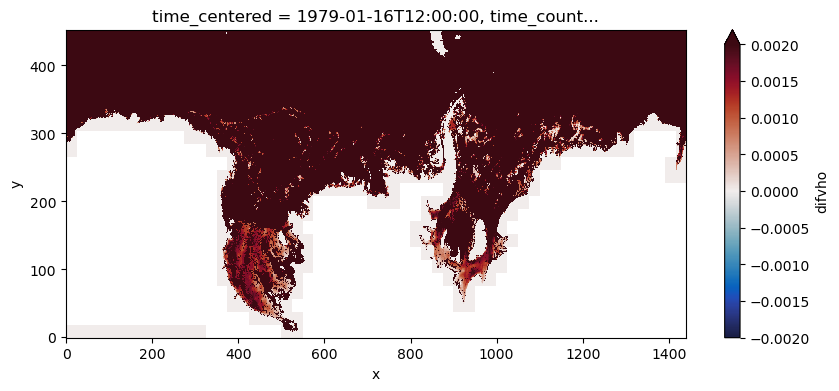

In [33]:
ds_off.difvho.isel(time_counter=0).mean(dim='depthw').plot(figsize=(10,4), vmin=-2e-3, vmax=2e-3, cmap=cmocean.cm.balance)

In [3]:
# regions:
weddell_basin      = {'x': slice(950, 1150, None), 'y': slice(295, 360, None)} # very similar to weddell convect but withwout shelf edge
weddell_west_shelf = {'x': slice(918, 967, None), 'y': slice(245, 310, None)}
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}

Look at what happens just at the shelfbreak:

In [4]:
def extract_region_var(run_dir, var_name, region, file_slice=(0,None), file_type='grid_T'):
    if file_type=='grid_W': 
        name_remapping1 = {'nav_lev':'depthw'}
        mask = 'tmask'
    elif file_type=='grid_T':
        name_remapping1 = {'nav_lev':'deptht'}
        mask = 'tmask'
    elif file_type=='grid_U': mask = 'umask'; name_remapping1={'nav_lev':'depthu'};
    elif file_type=='grid_V': mask = 'vmask'; name_remapping1={'nav_lev':'depthv'};

    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename(name_remapping1)
    
    files = glob.glob(f'{run_dir}eANT025*{file_type}*')[file_slice[0]:file_slice[1]]

    area_name='area'
    if file_type=='grid_T': area_name = 'area_grid_T'; name_remapping2 = {'area_grid_T':'area', 'x_grid_T':'x', 'y_grid_T':'y'}
    else: name_remapping2={} 
        
    kwags={'preprocess':lambda ds: ds[[var_name, area_name, 'time_counter']], 'chunks':'auto'}
    nemo_ds    = xr.open_mfdataset(files, **kwags).rename(name_remapping2)
    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = nemo_ds['area'].isel(time_counter=0).expand_dims({name_remapping1['nav_lev']:nemo_ds[name_remapping1['nav_lev']]})
    area_ocean = xr.where(nemo_mesh_ds[mask].values==0, np.nan, area_ocean)
    var_ocean  = xr.where(nemo_mesh_ds[mask].values==0, np.nan, nemo_ds[var_name])
    var_ocean  = xr.where(var_ocean==0, np.nan, var_ocean)

    region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    region_var = xr.where(region_var==0, np.nan, region_var)

    return region_var, var_ocean

In [5]:
def plot_hovmoeller(region_var, ylim=(1600, 0), vmin=0, vmax=1e-2, cmap=cmocean.cm.haline, grid_type='T'):

    if grid_type=='T': depth='deptht'
    elif grid_type=='W': depth='depthw'
    elif grid_type=='U': depth='depthu'
    elif grid_type=='V': depth='depthv'

    fig, ax = plt.subplots(1,1, figsize=(18,5))
    xx, yy = np.meshgrid(region_var.time_counter, region_var[depth])
    
    cb = ax.pcolormesh(xx.transpose(), yy.transpose(), region_var, vmin=vmin, vmax=vmax, cmap=cmap, norm=colors.LogNorm())
    
    fig.colorbar(cb, ax=ax)
    ax.set_ylim(ylim[0], ylim[1])

    return fig, ax

In [6]:
run_dir = f'{base_dir}output/ERA5_test6_highres/files/'
time_slice=(90,240)#-1)

region = weddell_overall

# weddell_vdiff, vdiff = extract_region_var(run_dir, 'difvho' , region, file_slice=time_slice, file_type='grid_W')
weddell_vdiff, vdiff = extract_region_var(run_dir, 'difvho' , region, file_slice=time_slice, file_type='grid_W')
# weddell_Uvel,  Uvel  = extract_region_var(run_dir, 'uo'     , region, file_slice=time_slice, file_type='grid_U')
# weddell_Vvel,  Vvel  = extract_region_var(run_dir, 'vo'     , region, file_slice=time_slice, file_type='grid_V')
# weddell_T, T         = extract_region_var(run_dir, 'thetao' , region, file_slice=time_slice, file_type='grid_T')
# weddell_S, S         = extract_region_var(run_dir, 'so'     , region, file_slice=time_slice, file_type='grid_T')

In [9]:
# weddell_basin_shear = ((weddell_basin_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
                       # (weddell_basin_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))
# weddell_shelf_shear = ((weddell_shelf_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
#                        (weddell_shelf_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))

# weddell_basin_rho = gsw.density.rho(weddell_basin_S, weddell_basin_T, weddell_basin_T.deptht) # nemo_mesh_ds.deptht
# weddell_basin_N2  = -9.81*1e-3*weddell_basin_rho.diff(dim='deptht')
weddell_rho = gsw.density.rho(weddell_S, weddell_T, weddell_T.deptht) # nemo_mesh_ds.deptht
weddell_N2  = -9.81*1e-3*weddell_rho.diff(dim='deptht')

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


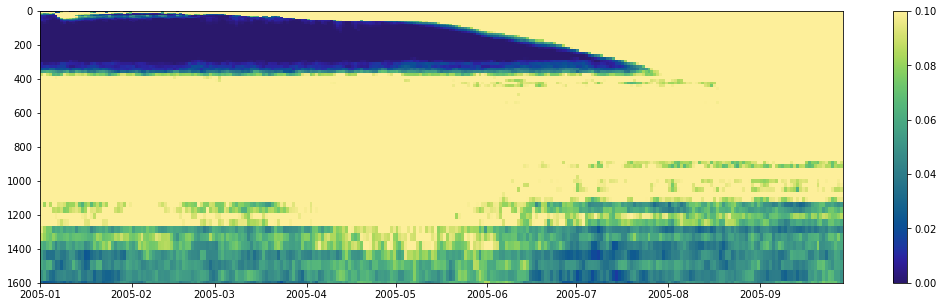

In [8]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_vdiff, grid_type='W', vmin=0, vmax=1e-1)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


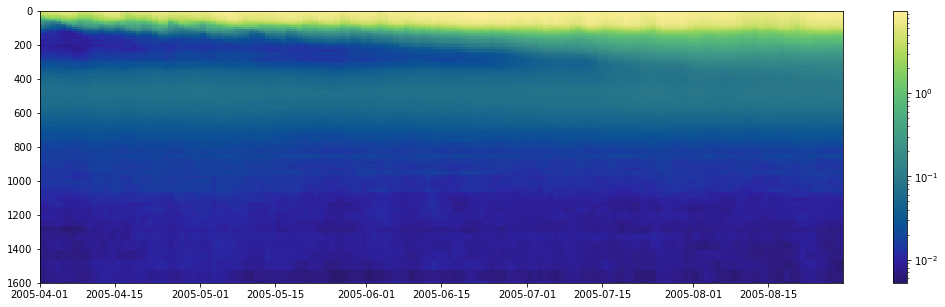

In [8]:
fig1, ax1 = plot_hovmoeller(weddell_vdiff, grid_type='W', vmin=None, vmax=None)#, vmin=0, vmax=1e-2)

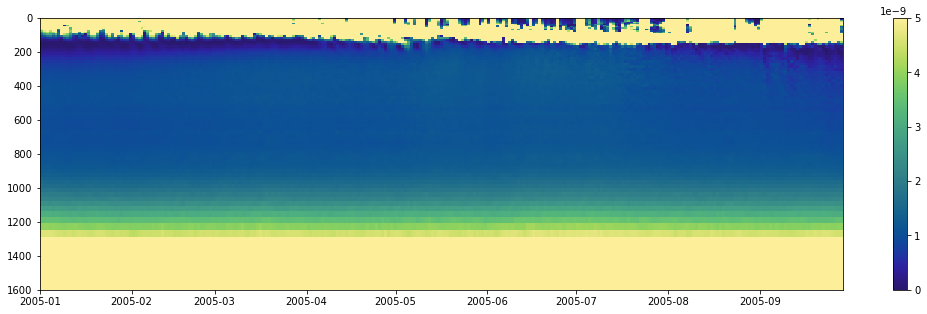

In [10]:
fig1, ax1 = plot_hovmoeller(weddell_basin_shear, grid_type='T', vmin=0, vmax=5e-9)

Or is the strong shear at the shelf break depth a consequence of the way I've calculated vertical shear? 

weddell_shelf_shear = ((weddell_shelf_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
                       (weddell_shelf_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))

In [8]:
Uvel_shelf = weddell_shelf_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2 
Vvel_shelf = weddell_shelf_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2

In [31]:
Uvel_diff = Uvel.diff(dim='depthu').rename({'depthu':'deptht'})
Vvel_diff = Vvel.diff(dim='depthv').rename({'depthv':'deptht'})

In [98]:
weddell_shelf_rho = gsw.density.rho(S, T, T.deptht)

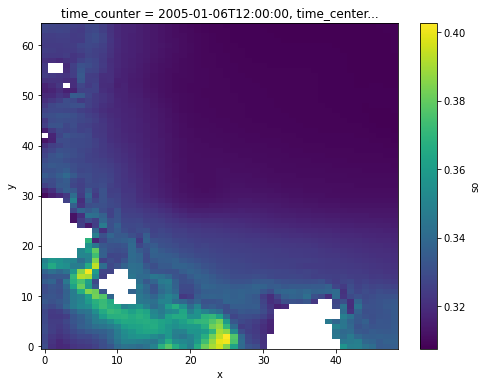

In [89]:
a = (weddell_shelf_rho).isel(time_counter=5, deptht=40)
b = (weddell_shelf_rho).isel(time_counter=5, deptht=44)
(b-a).plot(figsize=(8,6))

Could consider shortening the time step in case it's caused by instabilities

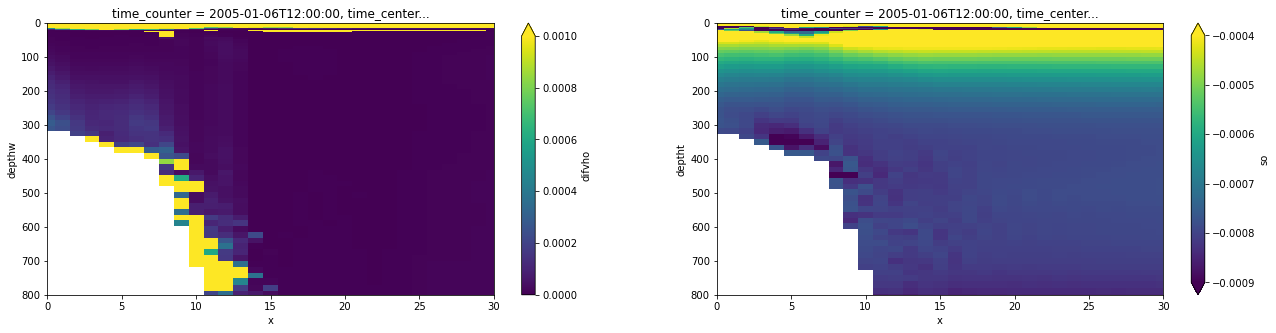

In [120]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
vdiff.isel(time_counter=5, y=23).plot(ax=ax[0], ylim=(800,0), xlim=(0,30), vmin=0, vmax=1e-3)
(-9.81*1e-3*weddell_shelf_rho.diff(dim='deptht')).isel(time_counter=5, y=23).plot(ax=ax[1], ylim=(800,0), xlim=(0,30), 
                                                                          vmin=-9e-4, vmax=-4e-4)

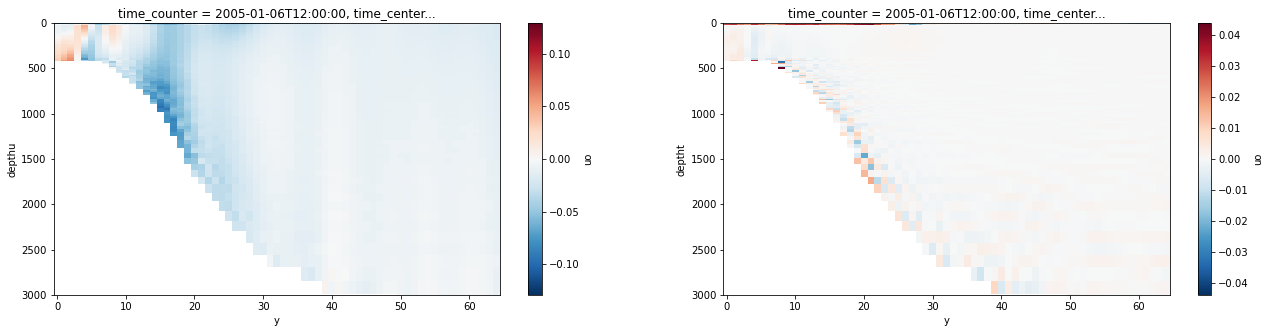

In [49]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
Uvel.isel(time_counter=5, x=23).plot(ax=ax[0], ylim=(3000, 0))
Uvel_diff.isel(time_counter=5, x=23).plot(ax=ax[1], ylim=(3000, 0))

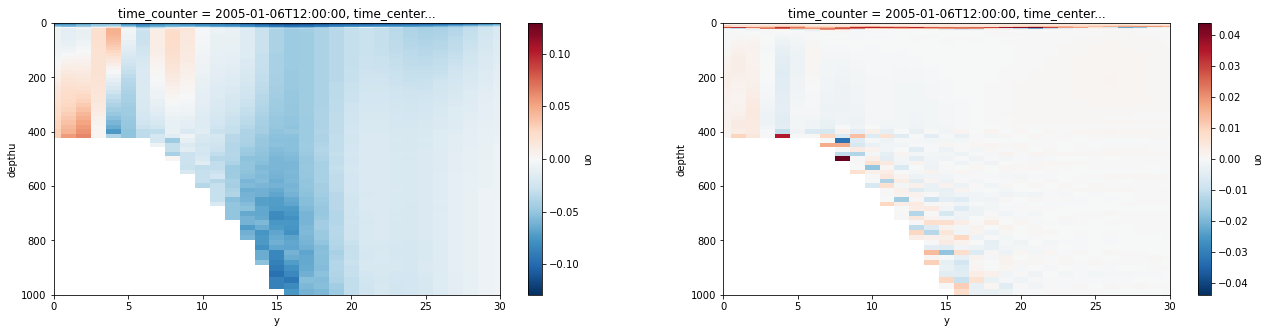

In [52]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
Uvel.isel(time_counter=5, x=23).plot(ax=ax[0], ylim=(1000,0), xlim=(0,30))
Uvel_diff.isel(time_counter=5, x=23).plot(ax=ax[1], ylim=(1000,0), xlim=(0,30))